In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from dataset import ClimateHackDataset
from basic_model import BasicModel
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Setup dataset and dataloader

In [3]:
DATASET_PATH = "eumetsat_seviri_hrv_uk.zarr"
#DATASET_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    DATASET_PATH,
    engine='zarr',
    chunks='auto'
)

Training Setup

In [4]:
BATCH_LEN = 16
EPOCHS = 20

In [5]:
cl_dataset = ClimateHackDataset(dataset, crops_per_slice=1)
cl_loader = DataLoader(cl_dataset, batch_size=BATCH_LEN)

Create the model

In [6]:
model = BasicModel()
model.to(device)

BasicModel(
  (layer0): Linear(in_features=196608, out_features=256, bias=True)
  (layer1): Linear(in_features=256, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=98304, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

Training utilities
# wow

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

Training loop definition

In [8]:
dir_to_save = 'basic_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [9]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch):
    its_til_checkpoint = 2
    
    running_loss = 0
    count = 0
    for i, (coords, features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i == 20:
            break
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')
            losses.append(curr_loss)

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
    
    losses.append(running_loss / count)

In [22]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

Iteration 0 - batch size: 16


In [10]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch)
    
    return losses

In [11]:
custom_set = dataset.sel(time=slice('2020-01-01 13:00:00', '2021-01-01 13:00:00'))

In [12]:
cl_dataset = ClimateHackDataset(custom_set, crops_per_slice=1)
model = BasicModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

Entering epoch 0
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45587658882141113


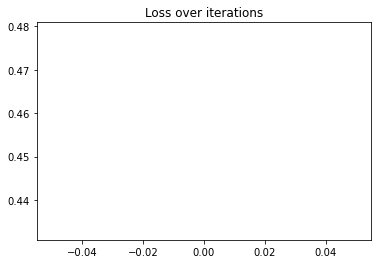

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4780943989753723


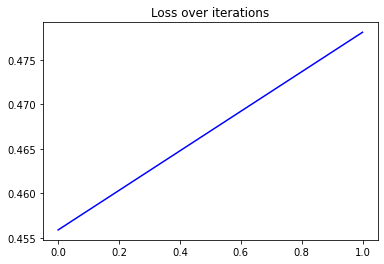

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.557174950838089


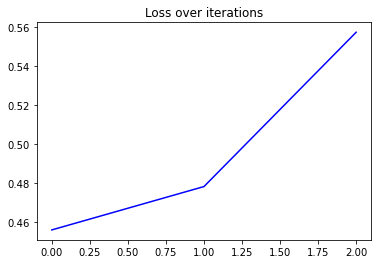

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5168248116970062


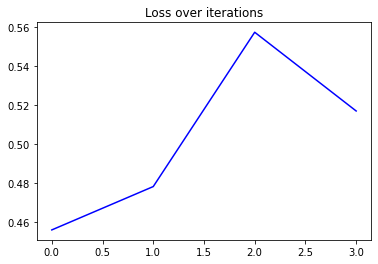

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.531172126531601


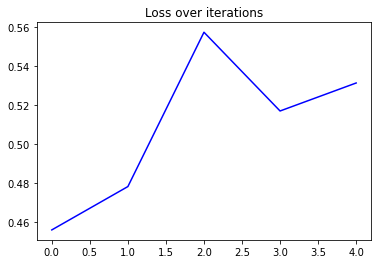

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6517647504806519


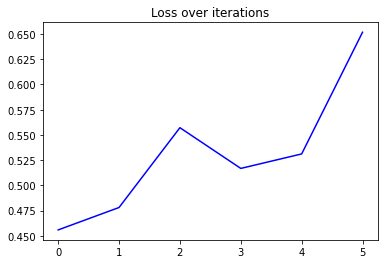

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6288018822669983


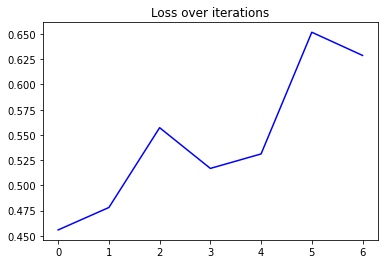

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6250201761722565


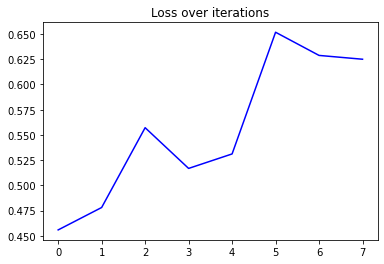

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6079879403114319


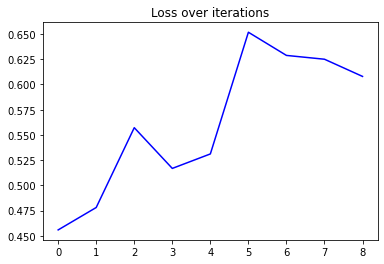

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.663258969783783


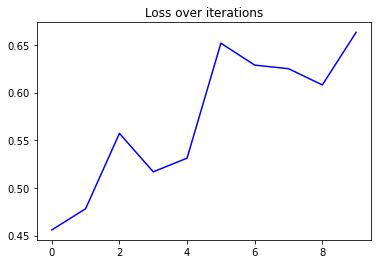

Iteration 20 - batch size: 16
Entering epoch 1
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4551297724246979


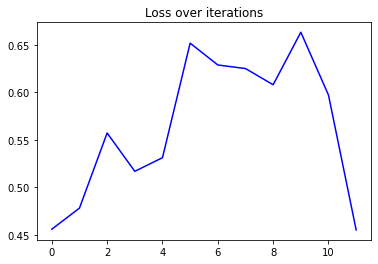

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47726893424987793


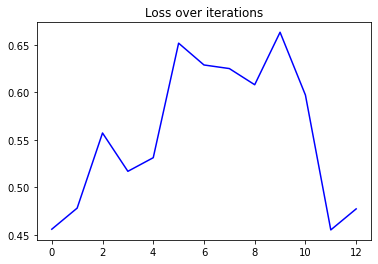

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.556133508682251


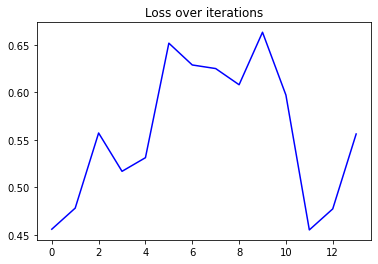

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5157438814640045


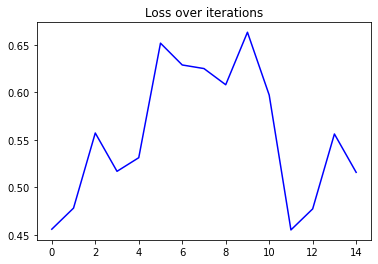

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5301754772663116


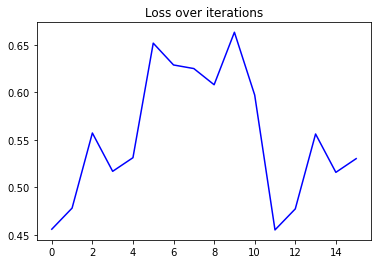

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6509019136428833


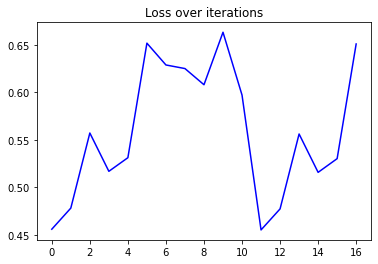

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.62808558344841


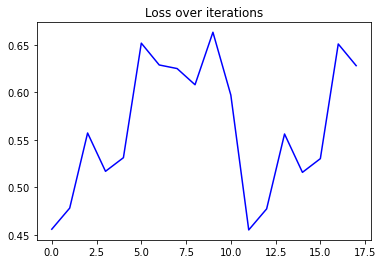

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6246548295021057


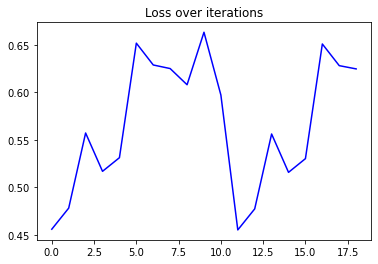

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6075304448604584


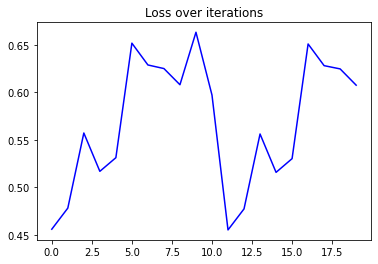

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6630661189556122


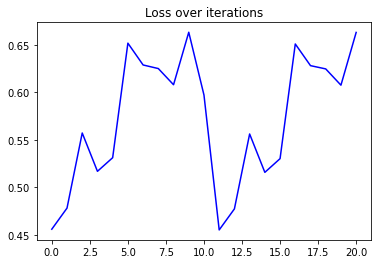

Iteration 20 - batch size: 16
Entering epoch 2
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4547679126262665


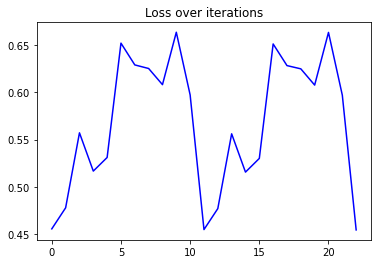

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4769761264324188


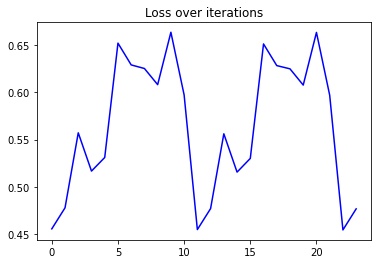

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5559202432632446


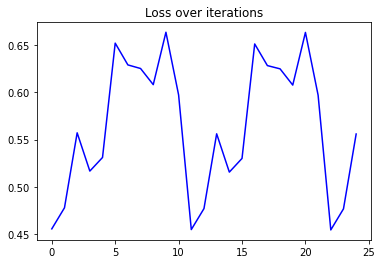

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155725181102753


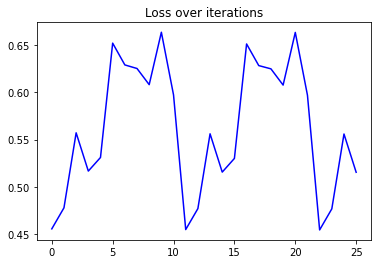

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300593972206116


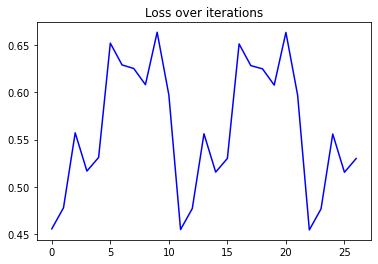

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6507570743560791


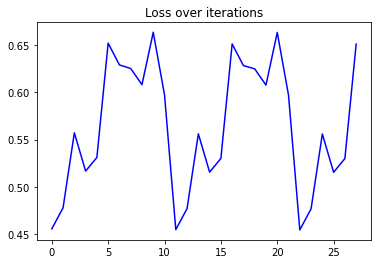

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279817521572113


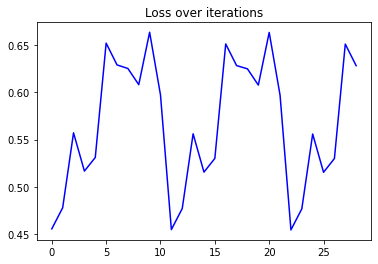

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6245335638523102


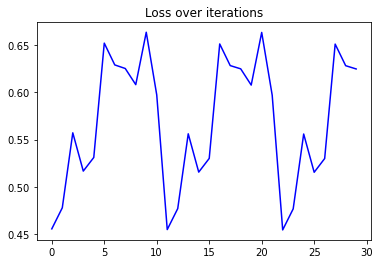

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6073721051216125


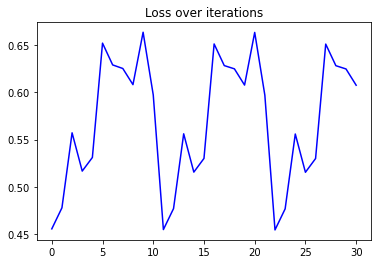

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6630320250988007


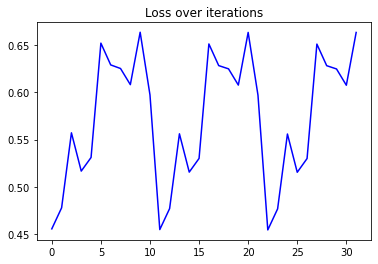

Iteration 20 - batch size: 16
Entering epoch 3
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4546853005886078


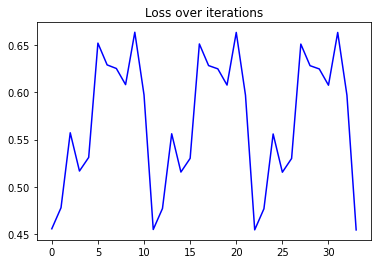

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4769233465194702


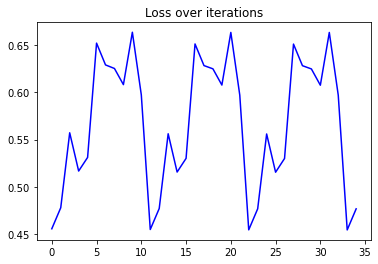

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.555869847536087


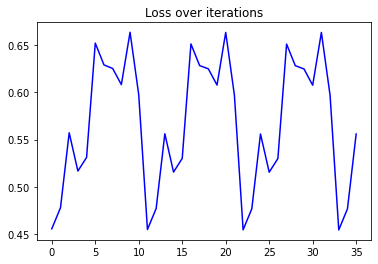

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155372619628906


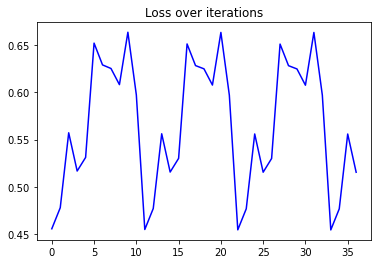

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300289392471313


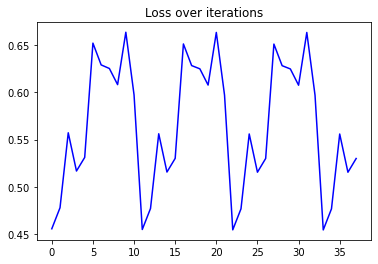

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506742238998413


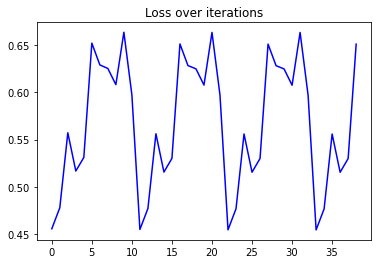

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.627955973148346


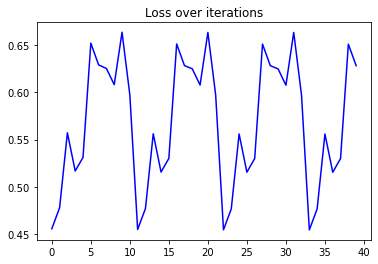

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244994103908539


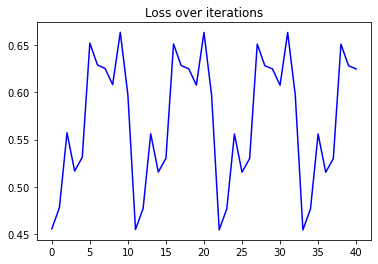

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.607323169708252


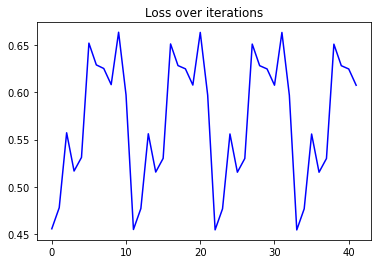

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6630068123340607


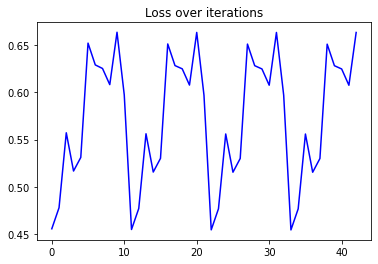

Iteration 20 - batch size: 16
Entering epoch 4
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4546549618244171


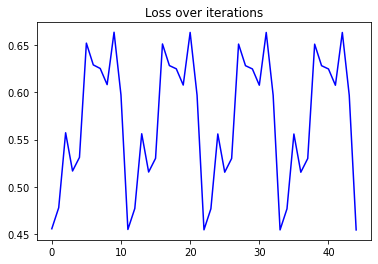

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47689932584762573


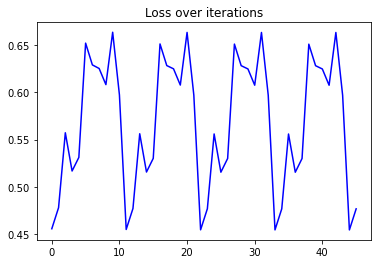

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558477640151978


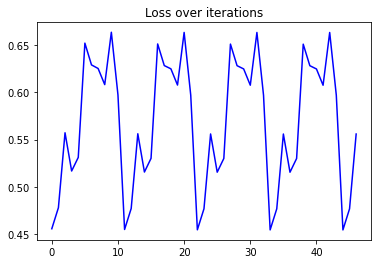

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155232548713684


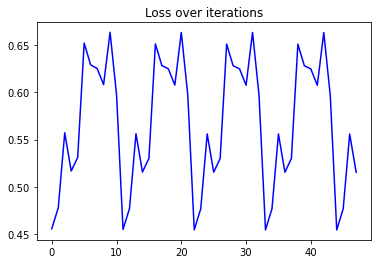

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300187468528748


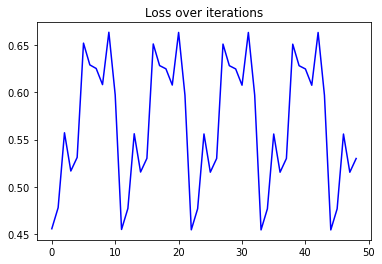

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506611406803131


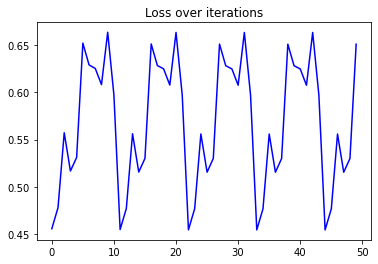

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279432475566864


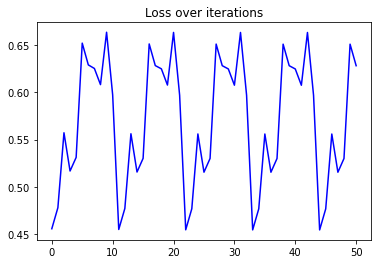

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244783401489258


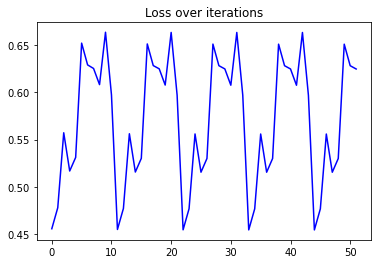

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6073037683963776


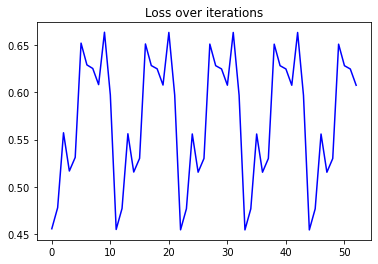

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6630036234855652


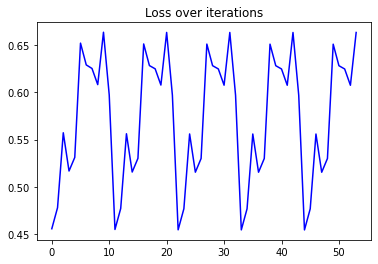

Iteration 20 - batch size: 16
Entering epoch 5
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4546428918838501


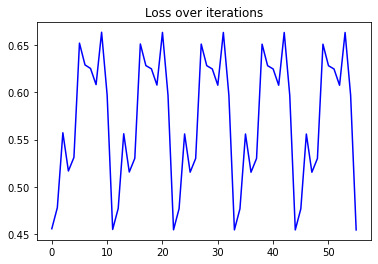

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768887162208557


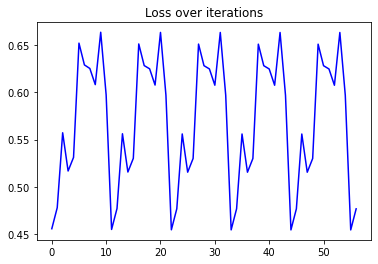

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558355450630188


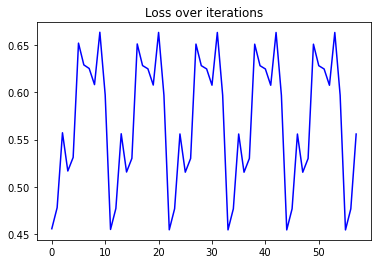

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155162811279297


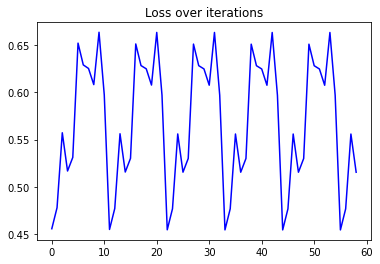

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300121307373047


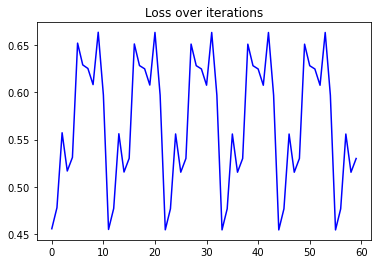

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.65064337849617


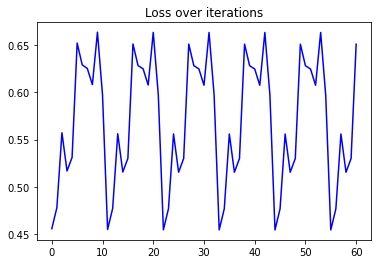

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279353201389313


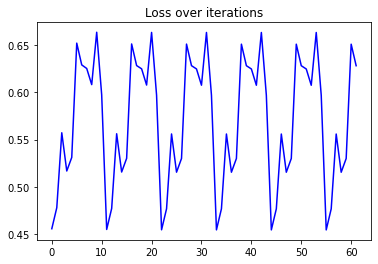

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244699060916901


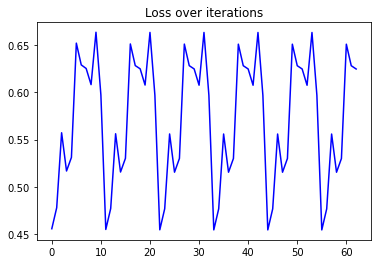

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072964668273926


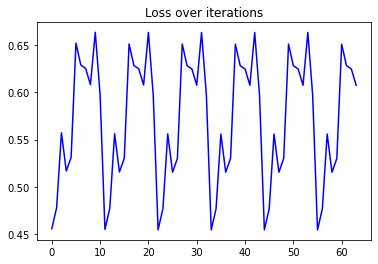

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629979610443115


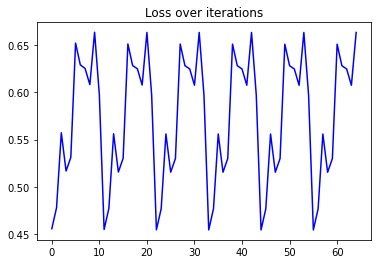

Iteration 20 - batch size: 16
Entering epoch 6
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45462948083877563


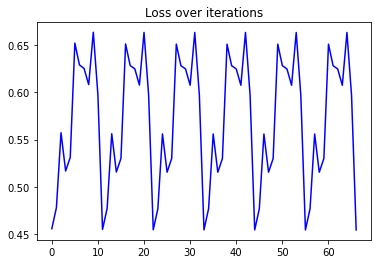

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768775701522827


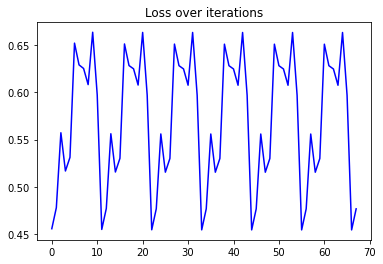

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558257102966309


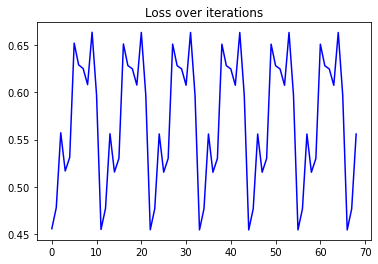

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155133008956909


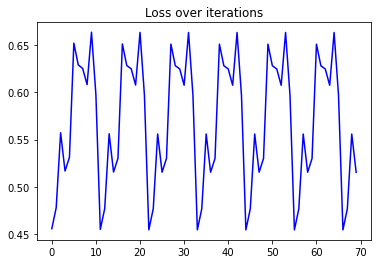

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300092995166779


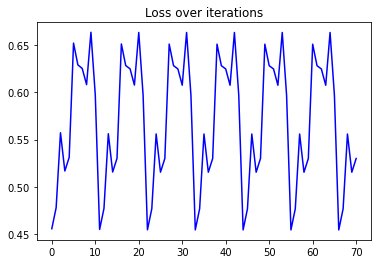

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.650642067193985


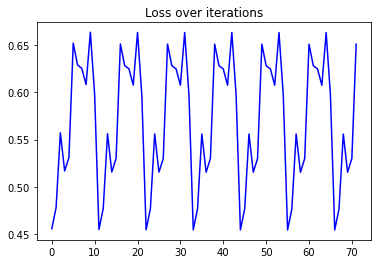

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279329061508179


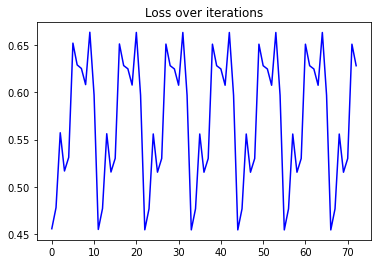

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.624464601278305


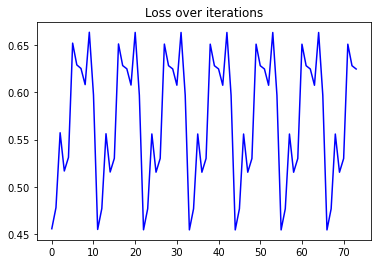

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072949171066284


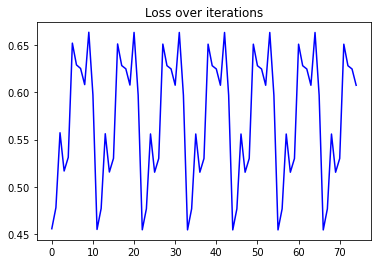

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629951596260071


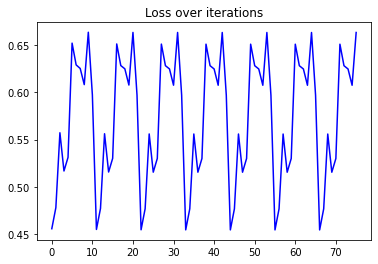

Iteration 20 - batch size: 16
Entering epoch 7
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4546222686767578


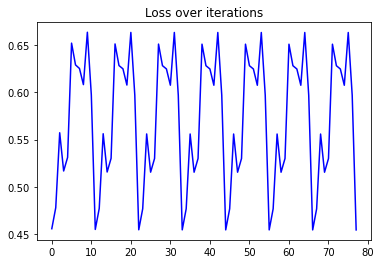

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.476872980594635


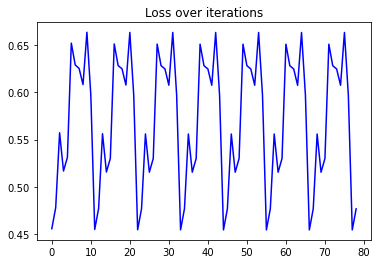

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558226108551025


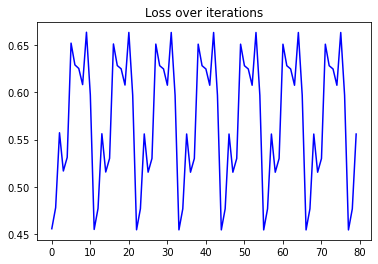

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155110955238342


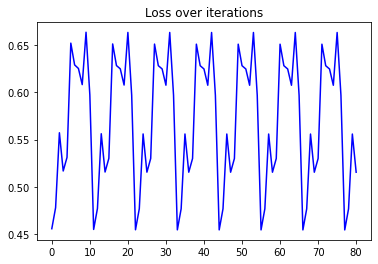

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300075113773346


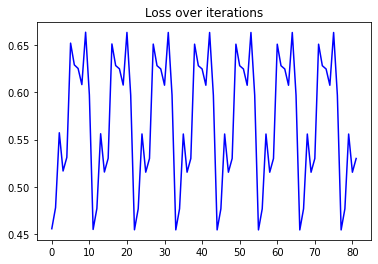

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506381332874298


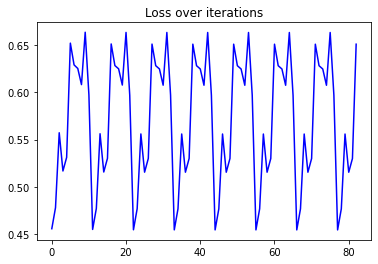

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279291808605194


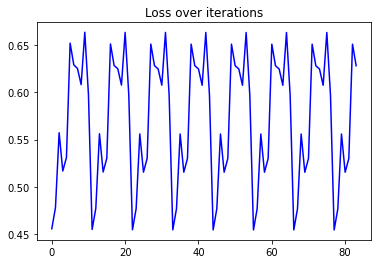

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244586110115051


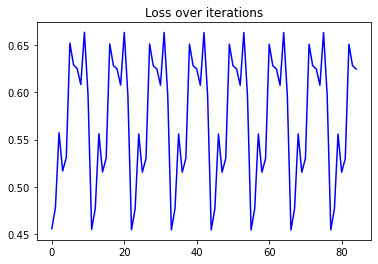

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072885394096375


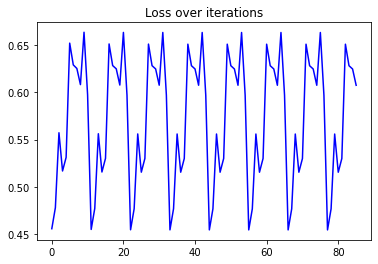

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629919707775116


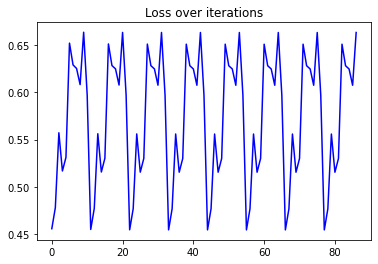

Iteration 20 - batch size: 16
Entering epoch 8
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.454619824886322


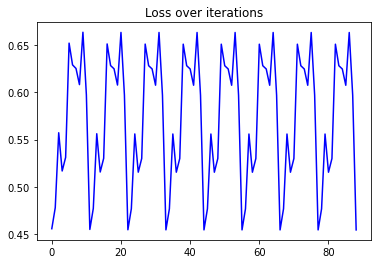

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768701195716858


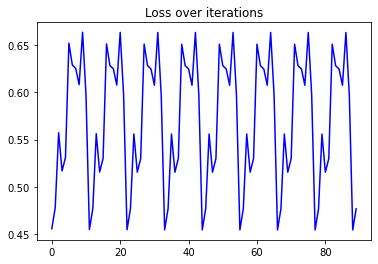

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558195412158966


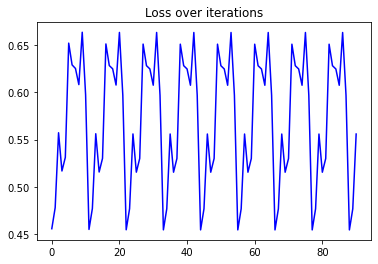

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155095458030701


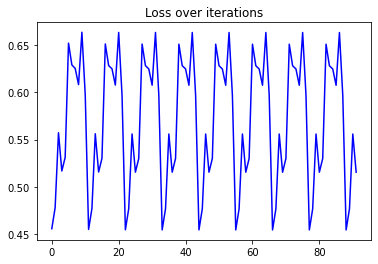

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300051867961884


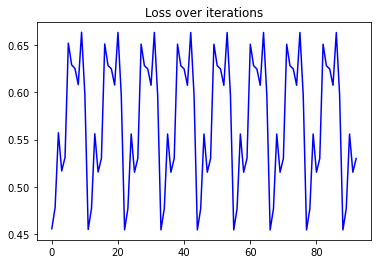

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506364345550537


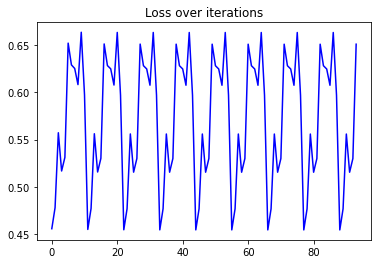

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279284954071045


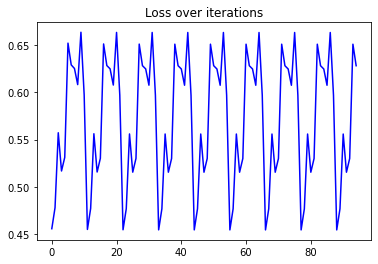

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244575381278992


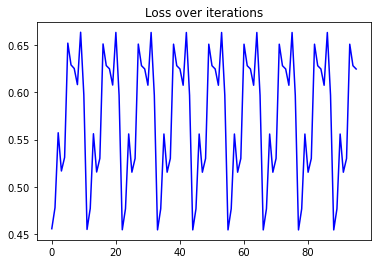

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072865128517151


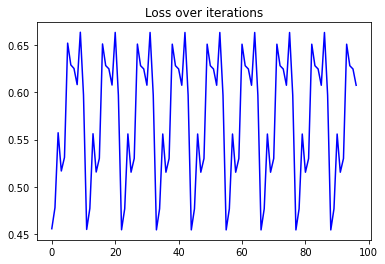

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629928946495056


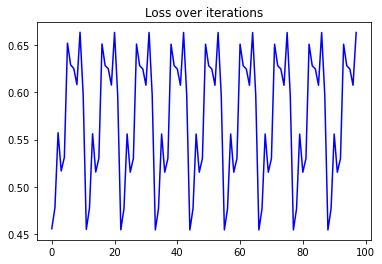

Iteration 20 - batch size: 16
Entering epoch 9
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4546138346195221


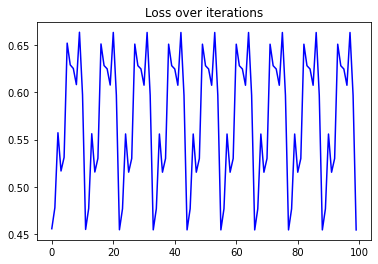

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768660366535187


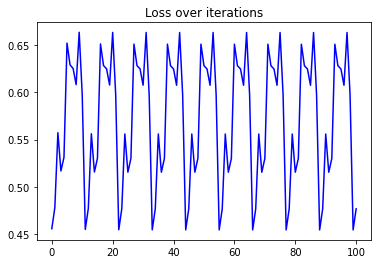

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558158457279205


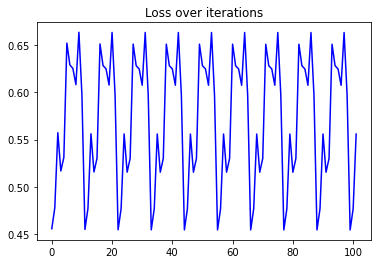

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155077278614044


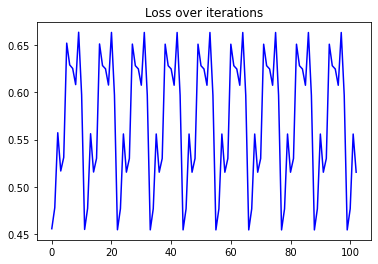

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300045311450958


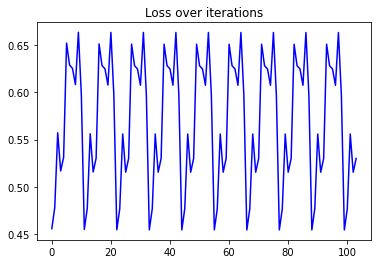

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506334543228149


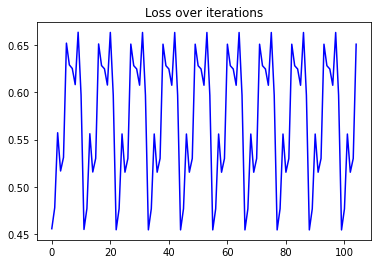

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279258728027344


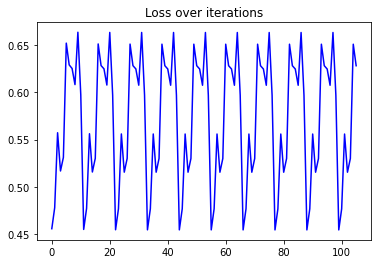

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244559288024902


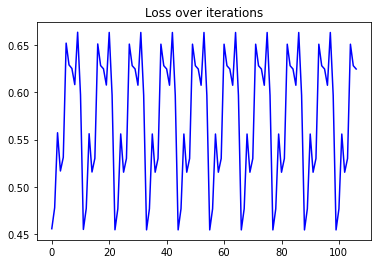

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072842478752136


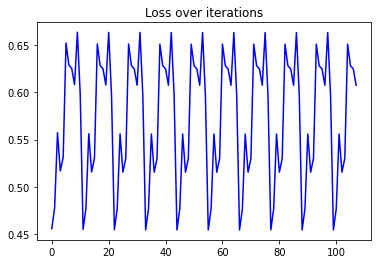

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629916131496429


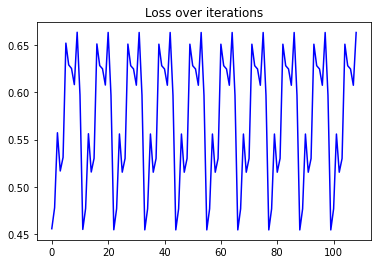

Iteration 20 - batch size: 16
Entering epoch 10
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45460933446884155


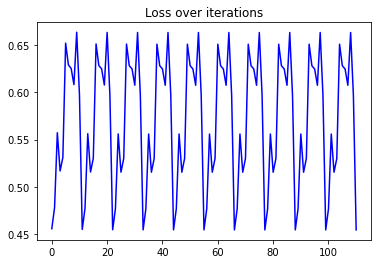

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768622815608978


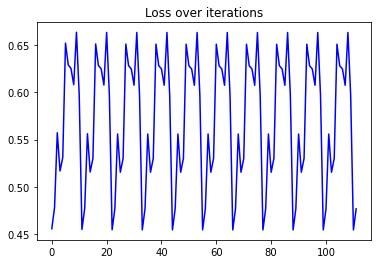

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558130145072937


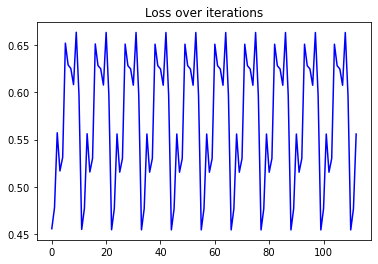

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155052840709686


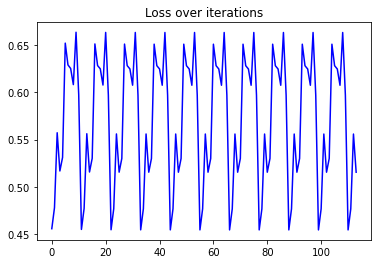

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300036668777466


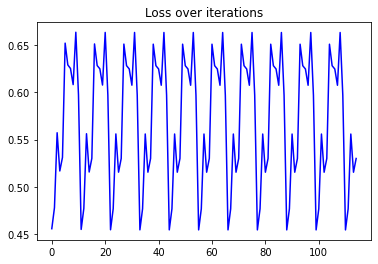

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506330668926239


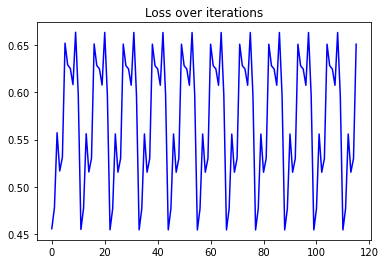

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.627924233675003


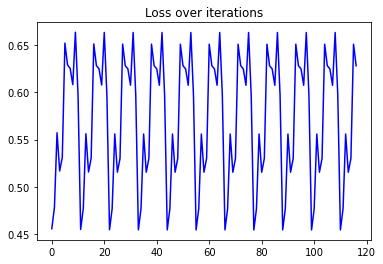

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244572103023529


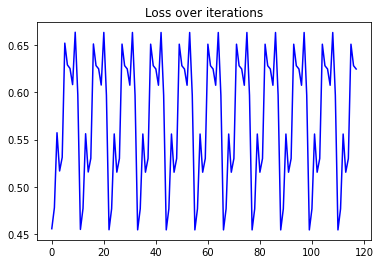

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.607285737991333


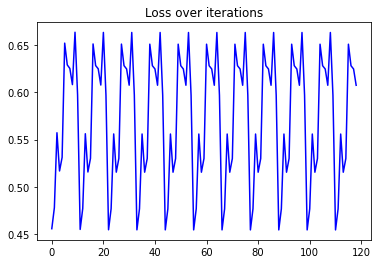

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629941165447235


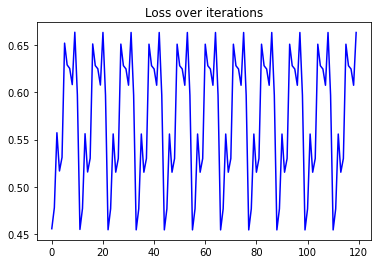

Iteration 20 - batch size: 16
Entering epoch 11
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45460402965545654


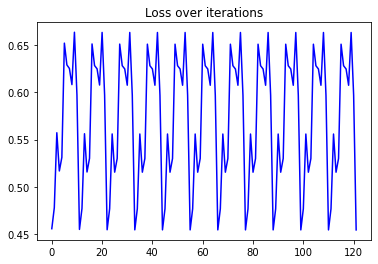

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.476858913898468


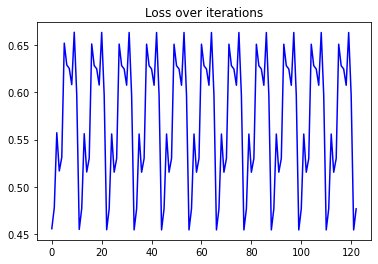

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558135807514191


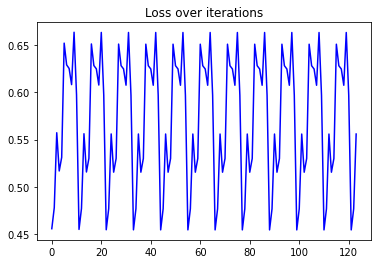

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155048668384552


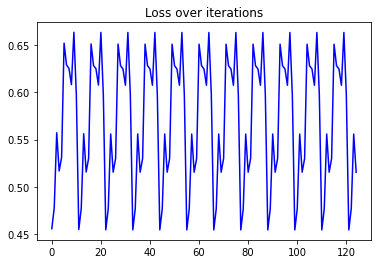

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300033688545227


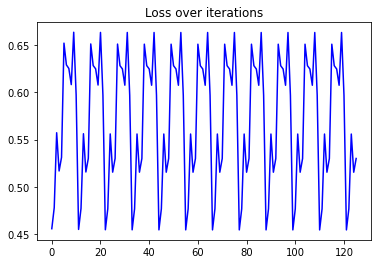

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506266891956329


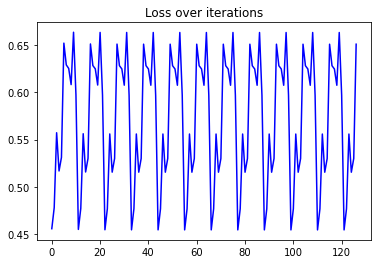

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279234886169434


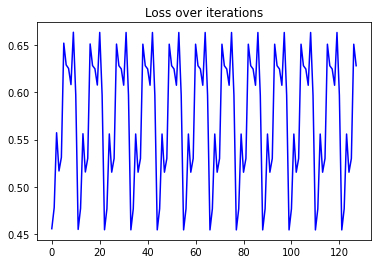

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244569420814514


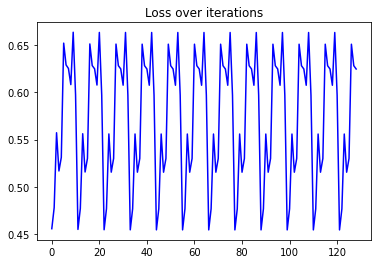

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072851419448853


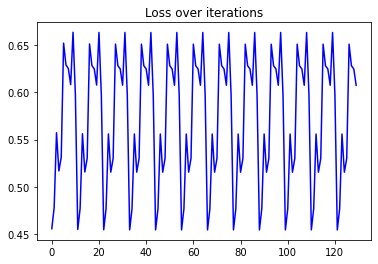

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629924774169922


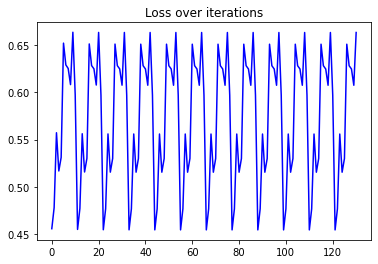

Iteration 20 - batch size: 16
Entering epoch 12
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4546019434928894


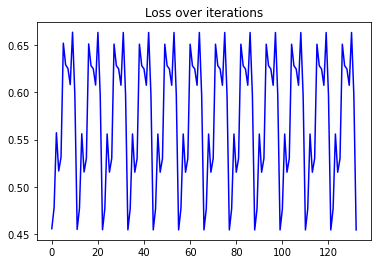

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768575429916382


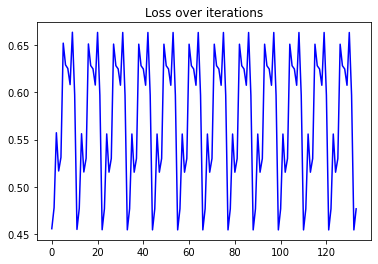

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558106303215027


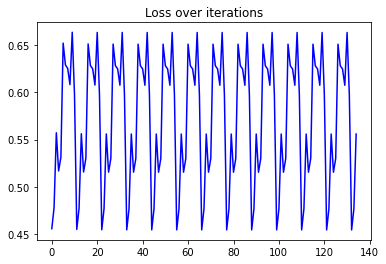

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155047476291656


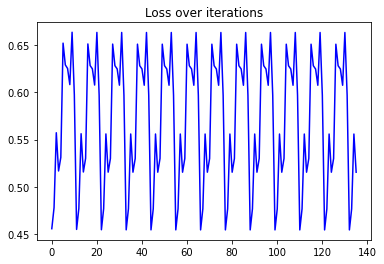

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300022959709167


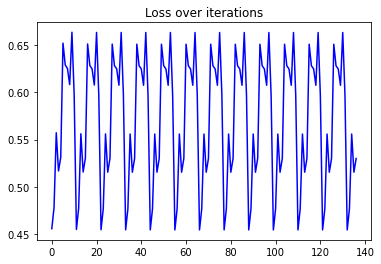

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506243944168091


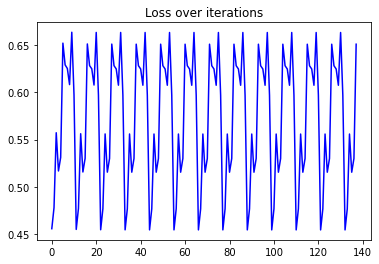

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279211342334747


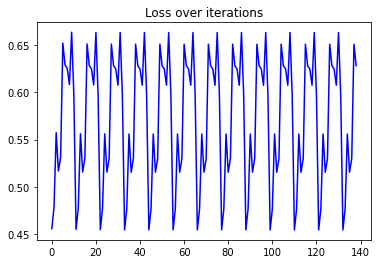

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244552433490753


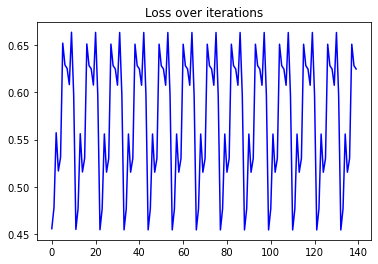

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072837710380554


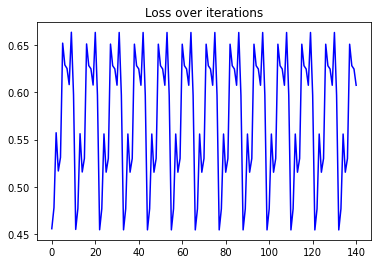

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.662991464138031


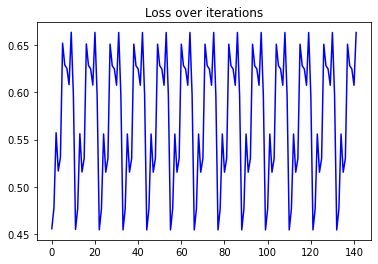

Iteration 20 - batch size: 16
Entering epoch 13
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45459866523742676


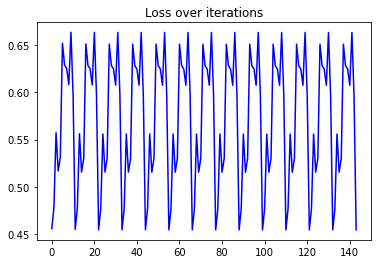

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768555164337158


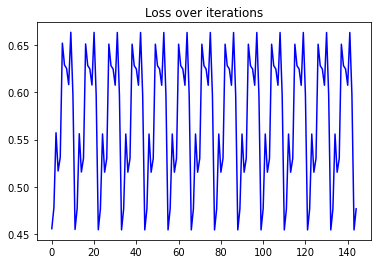

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558071732521057


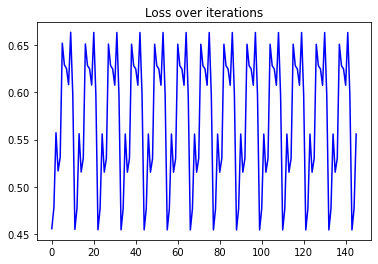

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155023038387299


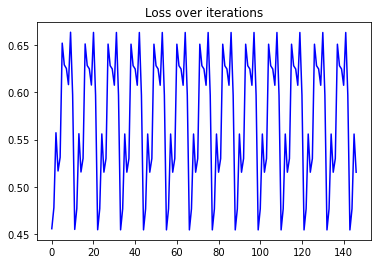

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300020277500153


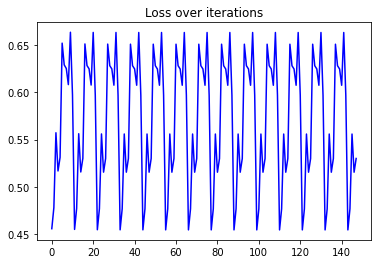

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506255269050598


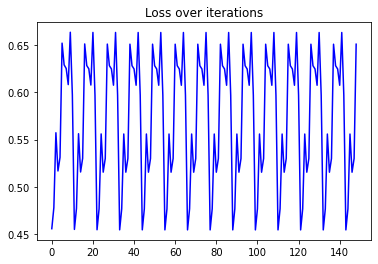

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279189884662628


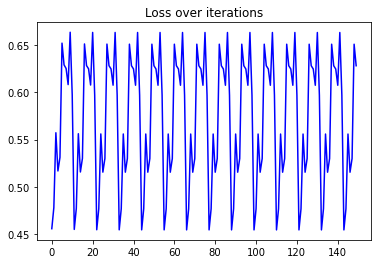

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244523227214813


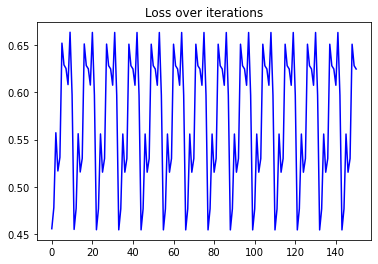

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072777509689331


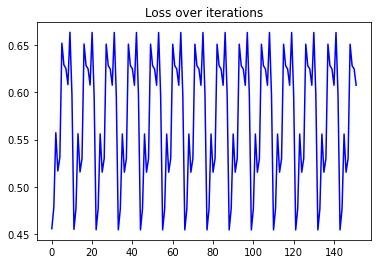

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629904806613922


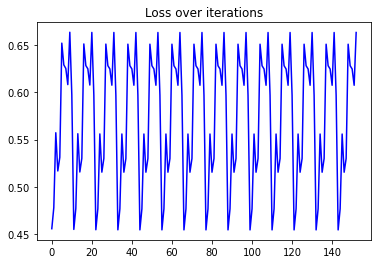

Iteration 20 - batch size: 16
Entering epoch 14
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4545981287956238


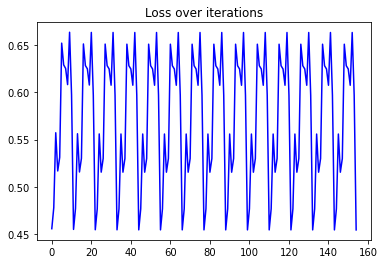

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.4768541157245636


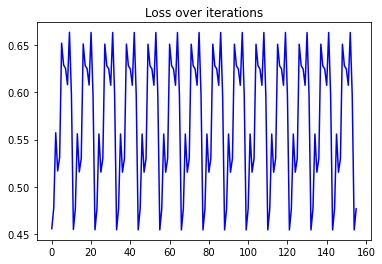

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558040738105774


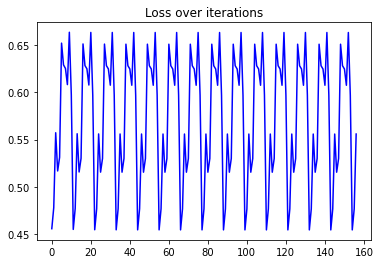

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5154996812343597


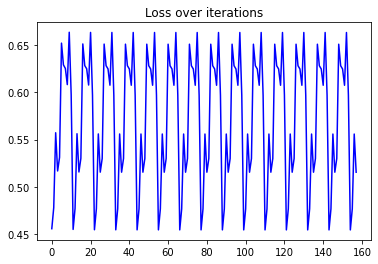

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300010442733765


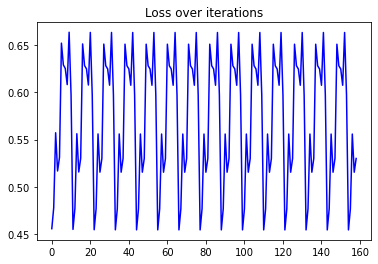

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506277620792389


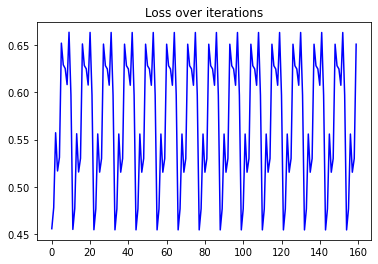

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279204785823822


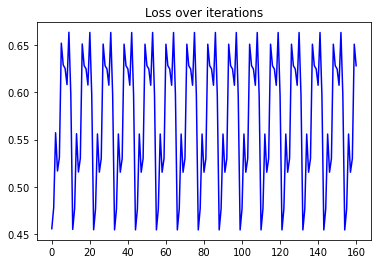

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244649291038513


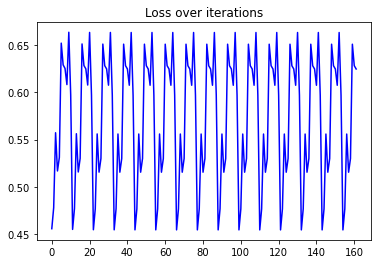

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072817444801331


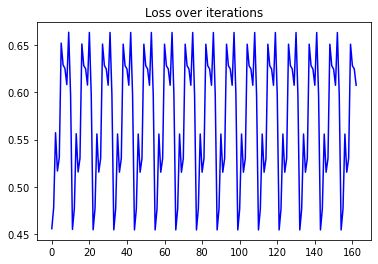

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629967987537384


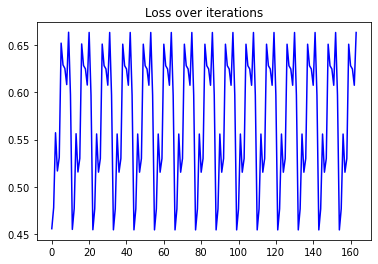

Iteration 20 - batch size: 16
Entering epoch 15
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45459336042404175


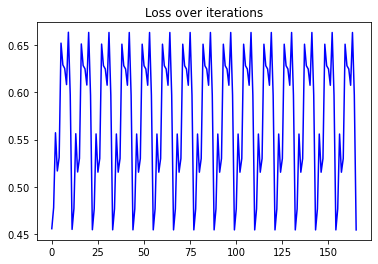

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47685086727142334


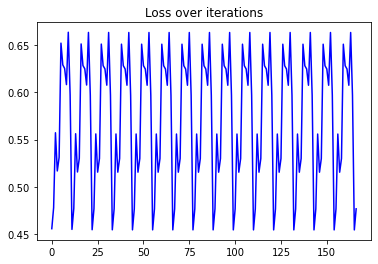

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558071434497833


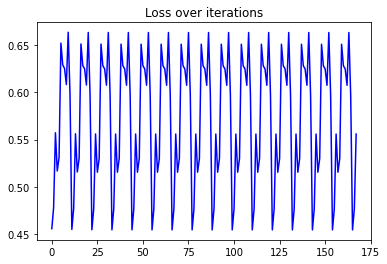

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155006945133209


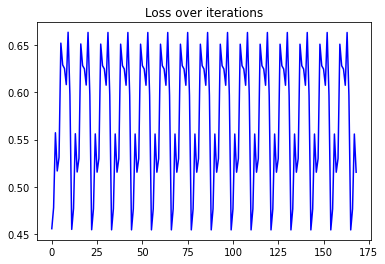

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5300039947032928


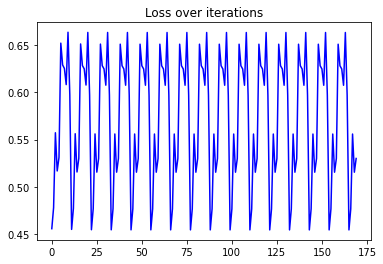

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506225764751434


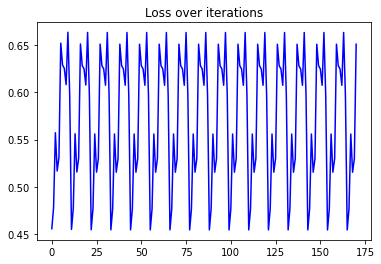

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.627919614315033


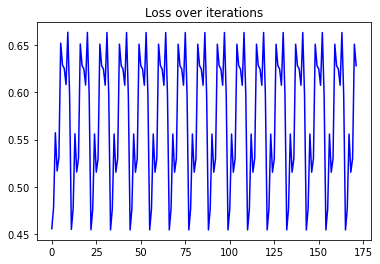

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244583427906036


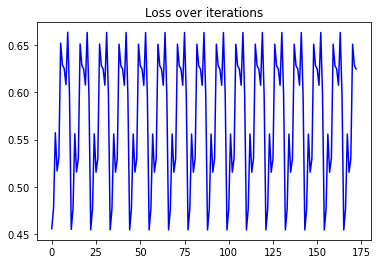

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072838008403778


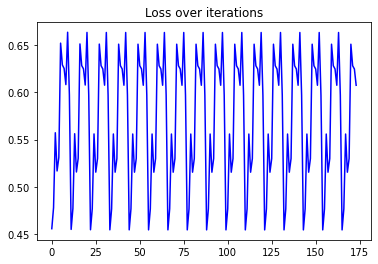

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629944145679474


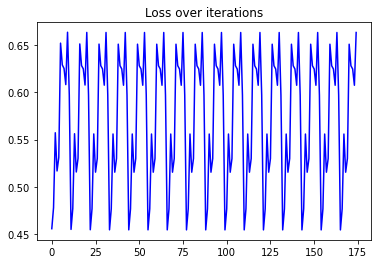

Iteration 20 - batch size: 16
Entering epoch 16
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.454593300819397


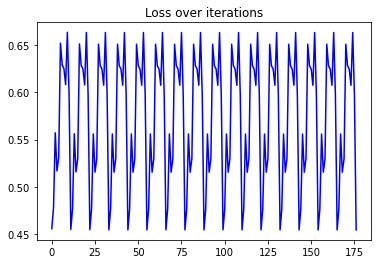

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47685179114341736


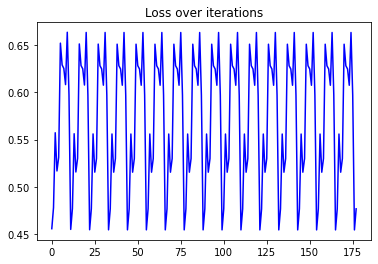

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5558055937290192


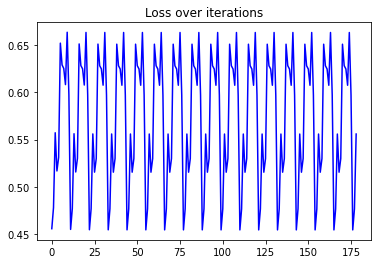

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5155005156993866


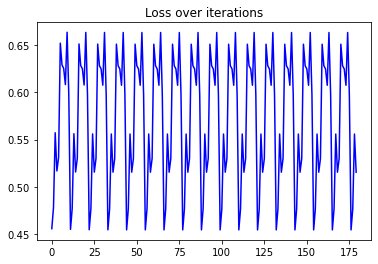

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5299985706806183


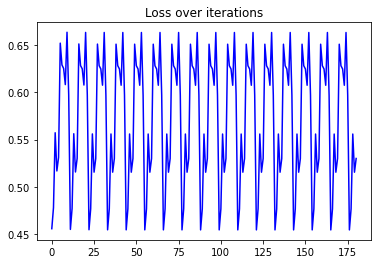

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506140232086182


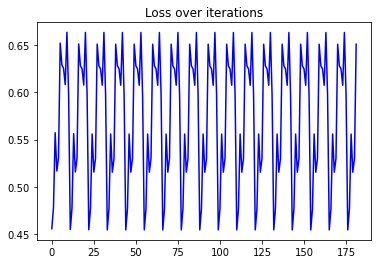

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279161870479584


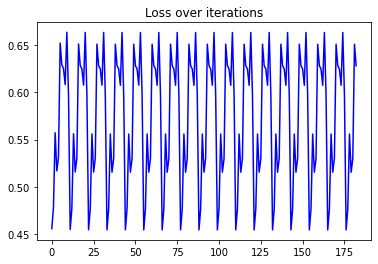

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244486272335052


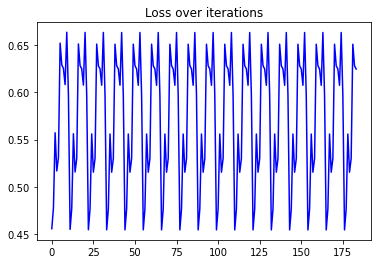

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072724163532257


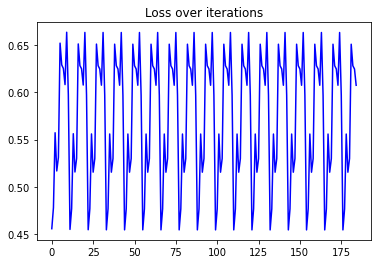

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629873812198639


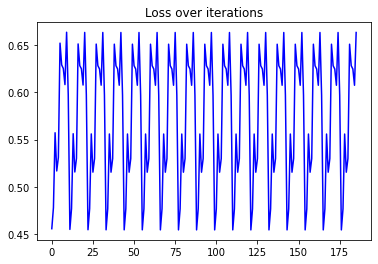

Iteration 20 - batch size: 16
Entering epoch 17
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4545941948890686


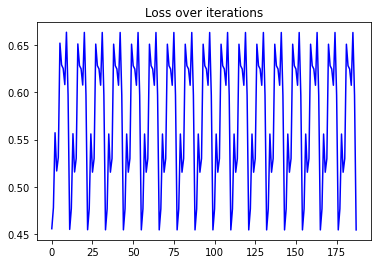

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47685107588768005


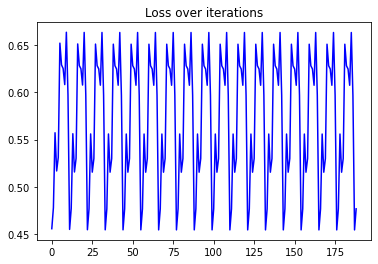

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.555801272392273


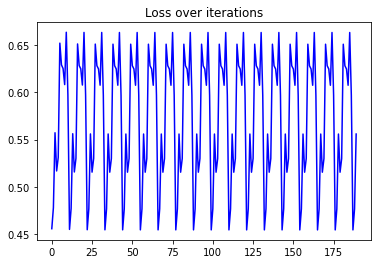

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5154986083507538


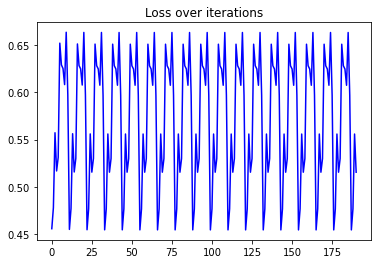

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5299994051456451


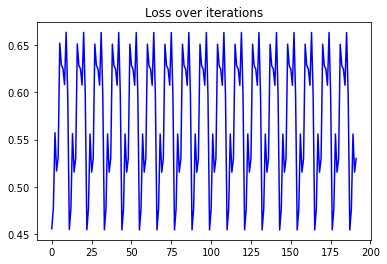

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506181955337524


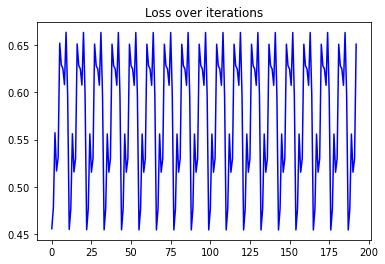

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279140114784241


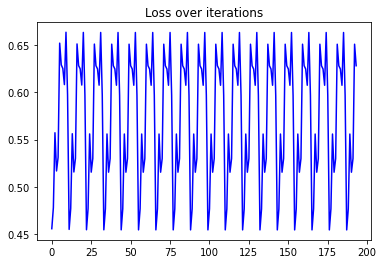

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244467496871948


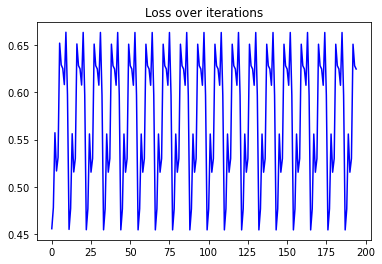

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072700619697571


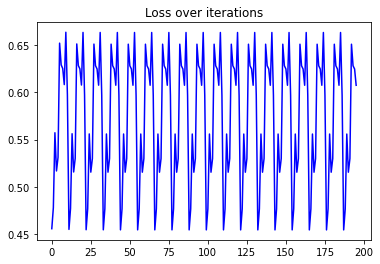

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629870533943176


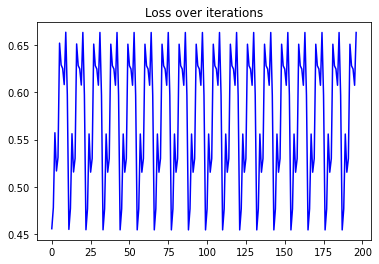

Iteration 20 - batch size: 16
Entering epoch 18
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.4545908570289612


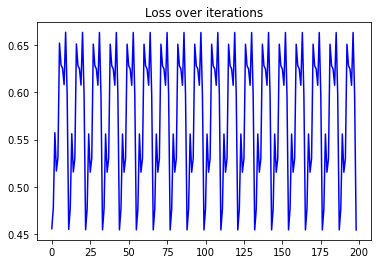

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47684890031814575


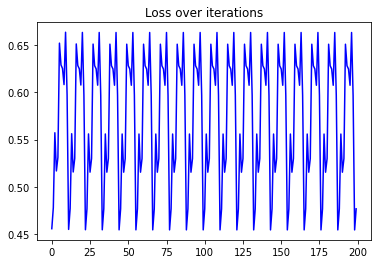

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5557984709739685


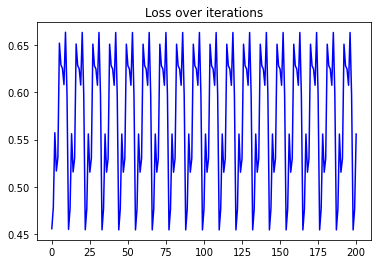

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.5154976546764374


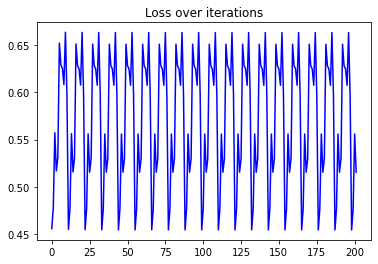

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.529998391866684


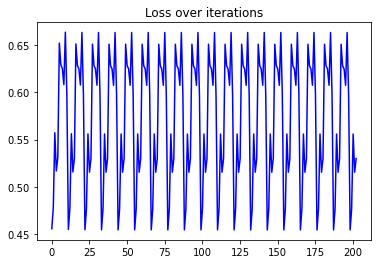

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506157517433167


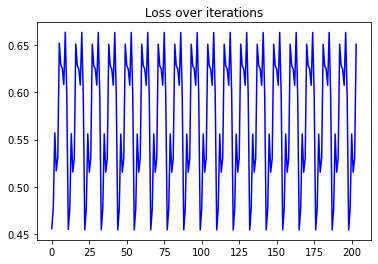

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279124021530151


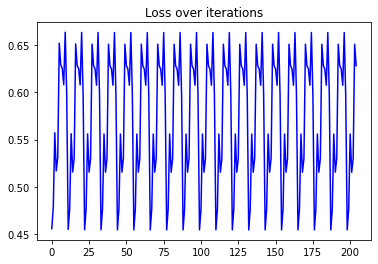

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244447827339172


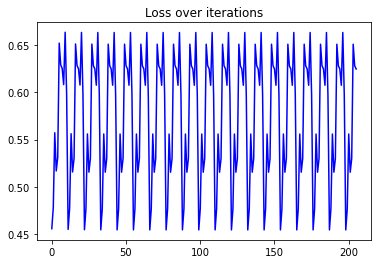

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072674095630646


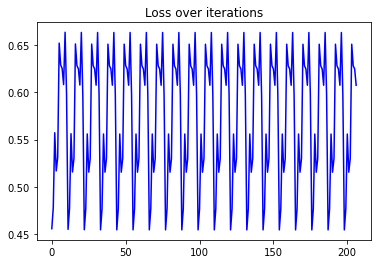

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629863083362579


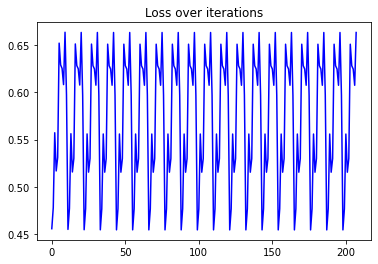

Iteration 20 - batch size: 16
Entering epoch 19
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.45458903908729553


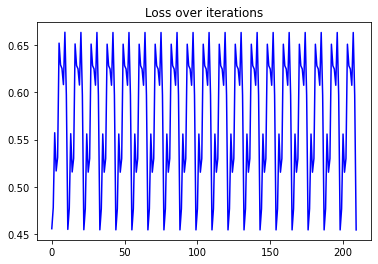

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.47684744000434875


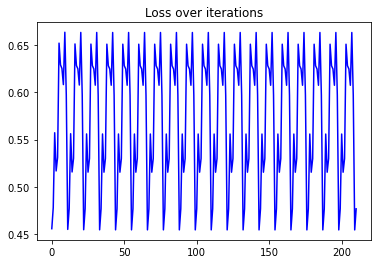

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.5557967126369476


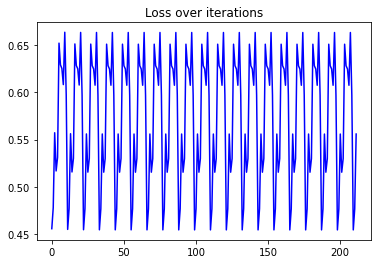

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.515496551990509


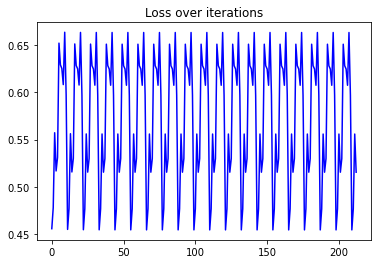

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.5299980938434601


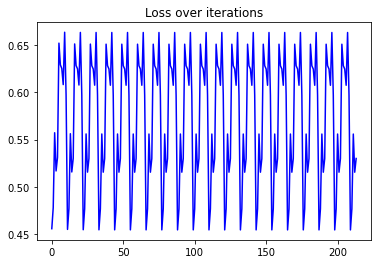

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.6506165862083435


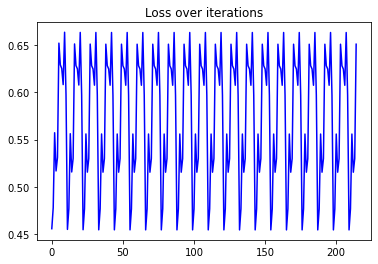

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.6279110610485077


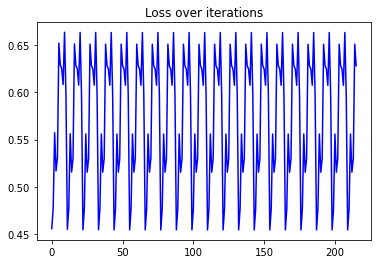

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.6244431734085083


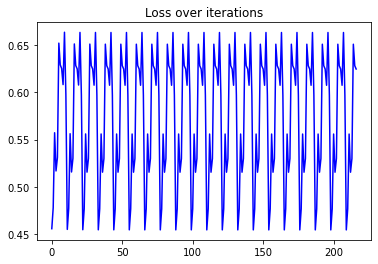

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.6072630882263184


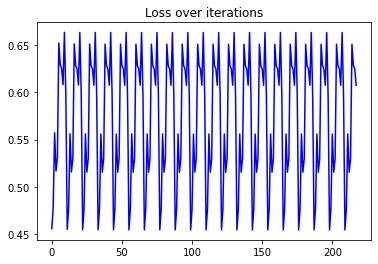

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.6629855632781982


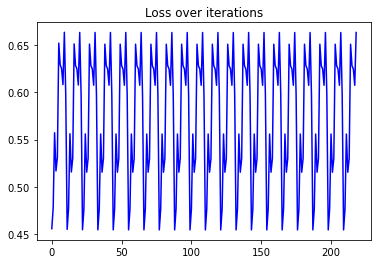

Iteration 20 - batch size: 16


[0.45587658882141113,
 0.4780943989753723,
 0.557174950838089,
 0.5168248116970062,
 0.531172126531601,
 0.6517647504806519,
 0.6288018822669983,
 0.6250201761722565,
 0.6079879403114319,
 0.663258969783783,
 0.597122073173523,
 0.4551297724246979,
 0.47726893424987793,
 0.556133508682251,
 0.5157438814640045,
 0.5301754772663116,
 0.6509019136428833,
 0.62808558344841,
 0.6246548295021057,
 0.6075304448604584,
 0.6630661189556122,
 0.5968502163887024,
 0.4547679126262665,
 0.4769761264324188,
 0.5559202432632446,
 0.5155725181102753,
 0.5300593972206116,
 0.6507570743560791,
 0.6279817521572113,
 0.6245335638523102,
 0.6073721051216125,
 0.6630320250988007,
 0.5968039035797119,
 0.4546853005886078,
 0.4769233465194702,
 0.555869847536087,
 0.5155372619628906,
 0.5300289392471313,
 0.6506742238998413,
 0.627955973148346,
 0.6244994103908539,
 0.607323169708252,
 0.6630068123340607,
 0.5967470407485962,
 0.4546549618244171,
 0.47689932584762573,
 0.5558477640151978,
 0.5155232548713684,

In [13]:
train(EPOCHS, cl_dataset, BATCH_LEN, model, optimizer, criterion)

#### Lets see the results


In [ ]:
for i, (coords, features, targets) in enumerate(cl_dataset):
    if i == 3:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [35]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()

NameError: name 'losses' is not defined